# BMW Forecast Project - M: + Power BI Hybrid Forecasting Pipeline
## 1. Project Introduction
This project builds an end-to-end forecasting pipeline to analyse and predict annual BMW sales across multiple Models and Regions. The workflow mimics a real-world analytics environment where data must be cleaned, aggregated, validated, tested, and deployed into reproducible forecasting routines.

Using a structured dataset of BMW vehicle sales, I:
- Perform exploratory data analysis (EDA) to validate data quality
- Aggregate the dataset into Model × Region × Year time series
- Evaluate the Prophet forecasting model using a strict temporal backtest
- Retrain models on the full sales history to produce 5-year forecasts
- Visualise results in a multi-panel forecast matrix
- Translate findings into actionable business insights and recommendations

This project demonstrates the full lifecycle of a forecasting solution—from raw data to evaluation to forward-looking insights—and showcases both technical skills and analytical reasoning.

## 2. Workflow Overview
The pipeline is organised into four phases:

1. Data Loading and EDA
   - Load the raw BMW sales dataset
   - Generate a reusable EDA profile (distributions, missing values, summary statistics)
   - Confirm there are no structural or missing-data issues
   - Save the cleaned fact table as Parquet for efficient reuse
2. Time-Series Preparation and Backtesting
   - Aggregate annual sales by Model × Region × Year
   - Apply an 80/20 time-based train/test split for each segment
   - Fit Prophet models on the training window and forecast the test years
   - Compute MAE, RMSE, and MAPE to measure accuracy
   - Generate a sorted MAPE heatmap to evaluate performance across segments
   - Identify high-confidence vs. low-confidence forecast segments
3. Full-History Forecasting
   - Retrain Prophet using the entire historical dataset per segment
   - Generate fitted values and a 5-year forward forecast
   - Combine results into a unified dataset containing Actual, Predicted, and MAPE%
   - Build a shared-axis, multi-panel forecast matrix:
      - Actuals = black lines
      - Forecasts = dashed lines colored by MAPE category (green → high confidence, red → low confidence)
   - Extract key executive insights
4. Recommendations
   - Summarise data-driven actions for planning, risk management, and model enhancement

**Result:**
This workflow delivers a robust forecasting system capable of evaluating model performance across 66+ independent time series, generating reliable forecasts where patterns are stable, and highlighting segments with higher uncertainty to support better planning and decision-making.



## 3. Data Cleaning and EDA

In [2]:
# Workspace setup
import os
import pandas as pd
import numpy as np

from prophet import Prophet

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import (
    is_numeric_dtype, is_datetime64_any_dtype, is_categorical_dtype, is_object_dtype
)



# ---- Paths (change if your structure is different) ----
EXPORT_DIR = "../exports"

os.makedirs(EXPORT_DIR, exist_ok=True)

Importing plotly failed. Interactive plots will not work.


Shape: 50,000 rows × 11 cols


,Model,Year,Region,Color,Fuel_Type,Transmission,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume,Sales_Classification
0,5 Series,2016,Asia,Red,Petrol,Manual,3.5,151748,98740,8300,High
1,i8,2013,North America,Red,Hybrid,Automatic,1.6,121671,79219,3428,Low
2,5 Series,2022,North America,Blue,Petrol,Automatic,4.5,10991,113265,6994,Low
3,X3,2024,Middle East,Blue,Petrol,Automatic,1.7,27255,60971,4047,Low
4,7 Series,2020,South America,Black,Diesel,Manual,2.1,122131,49898,3080,Low


,Column,Type,Non-Null,Missing,Unique,Mean,Std,Min,P25,Median,P75,Max,Notes
0,Model,object,50000,0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Top 10 levels: 7 Series (4666), i3 (4618), i8 ..."
1,Year,int64,50000,0,15,2017.01570,4.324459,2010.0,2013.00,2017.0,2021.00,2024.0,
2,Region,object,50000,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Top 6 levels: Asia (8454), Middle East (8373),..."
3,Color,object,50000,0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Top 6 levels: Red (8463), Silver (8350), Grey ..."
4,Fuel_Type,object,50000,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Top 4 levels: Hybrid (12716), Petrol (12550), ..."
5,Transmission,object,50000,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Top 2 levels: Manual (25154), Automatic (24846)"
6,Engine_Size_L,float64,50000,0,36,3.24718,1.009078,1.5,2.40,3.2,4.10,5.0,
7,Mileage_KM,int64,50000,0,44347,100307.20314,57941.509344,3.0,50178.00,100388.5,150630.25,199996.0,
8,Price_USD,int64,50000,0,38246,75034.60090,25998.248882,30000.0,52434.75,75011.5,97628.25,119998.0,
9,Sales_Volume,int64,50000,0,9845,5067.51468,2856.767125,100.0,2588.00,5087.0,7537.25,9999.0,


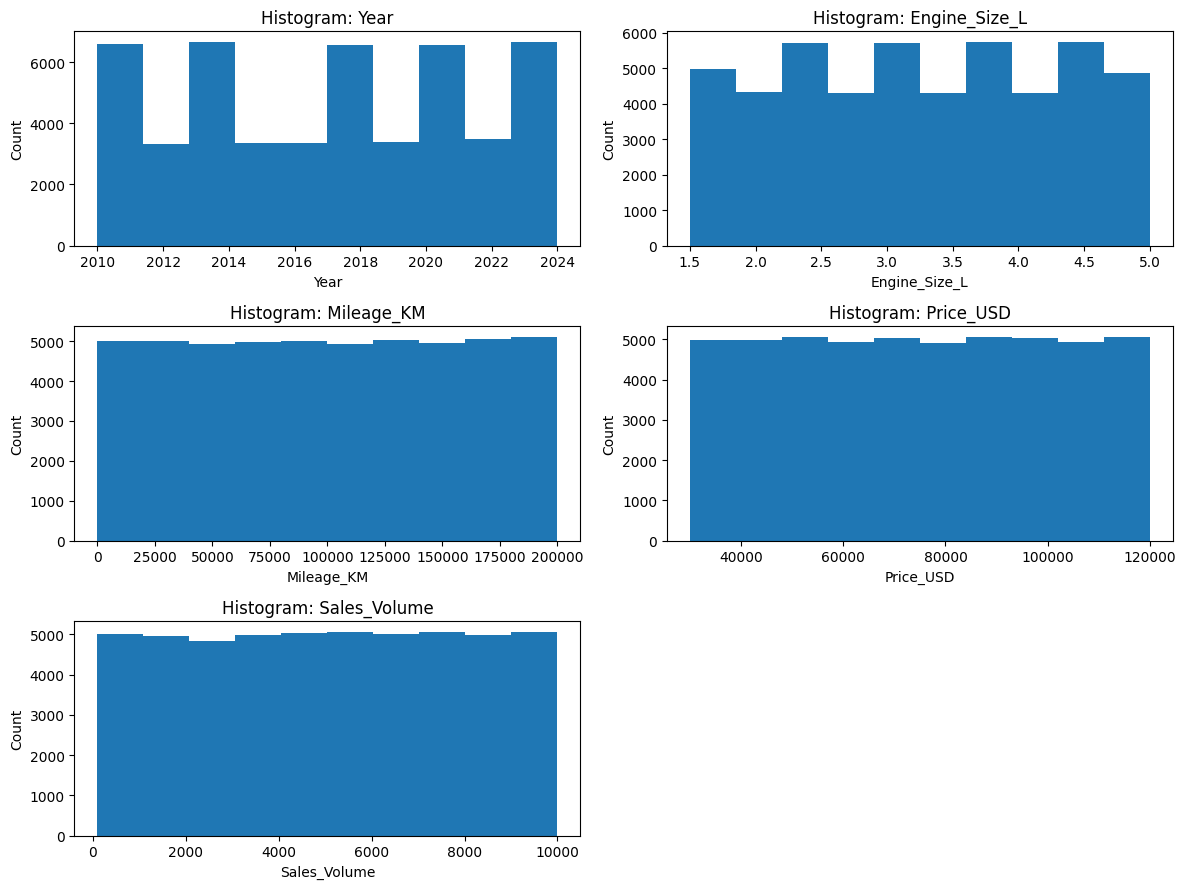

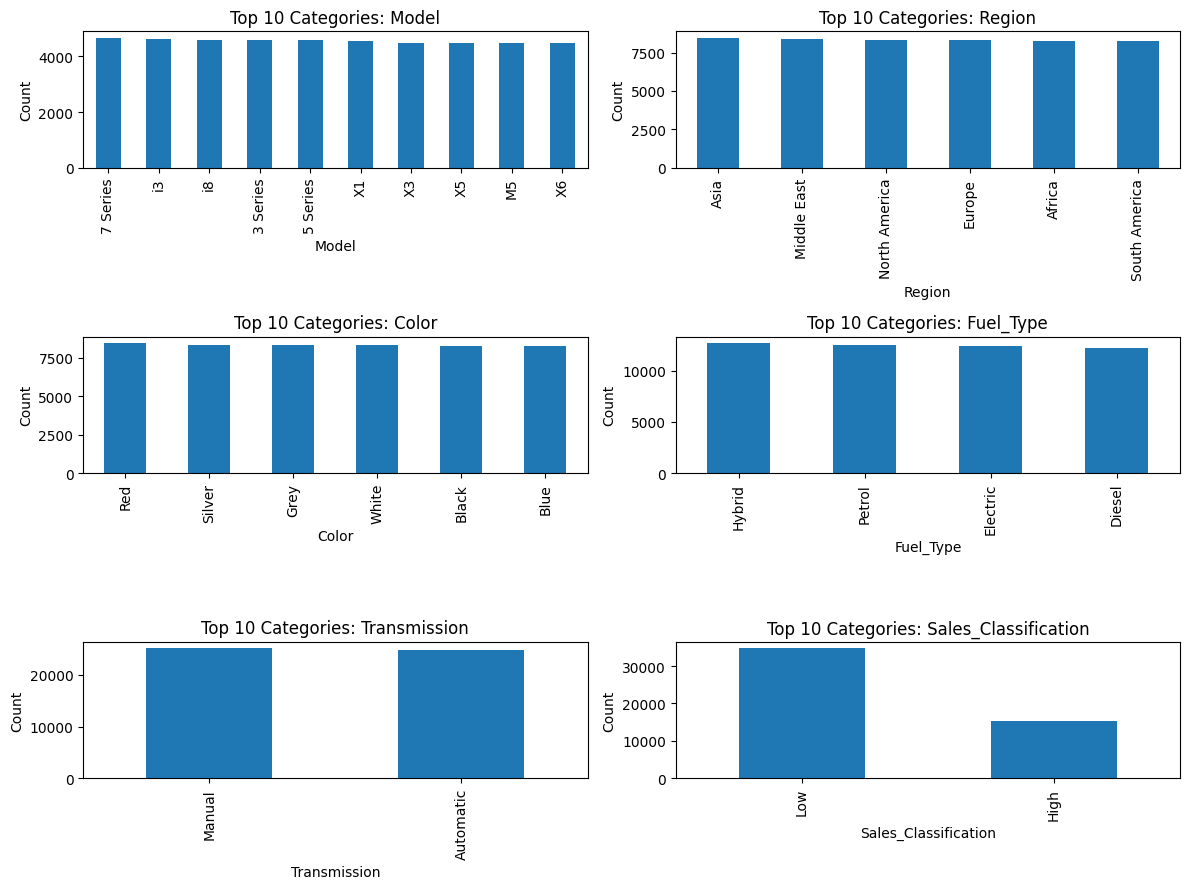

In [3]:
# Load & clean BMW dataset

# Load raw CSV
df_raw = pd.read_csv('../data/bmw_sales.csv')

# Reusable EDA analysis


# Perform ad-hoc analysis
def profile_dataframe(
    df: pd.DataFrame,
    sample_rows: int = 5,
    top_n_categories: int = 10,
    include_plots: bool = False,
    plot_max_cols: int = 8,
    plot_ncols: int =2
) -> pd.DataFrame:
    """
    Reusable EDA profiler for a pandas DataFrame.

    - Prints shape and shows a sample.
    - Returns a tidy column-wise summary (dtype, nulls, uniques, basic stats).
    - Optionally renders quick plots (hist for numeric, bar for categorical).

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame to explore.
    sample_rows : int, default 5
        Number of head rows to display.
    top_n_categories : int, default 10
        For categorical/object columns, show top-N levels (in Notes column).
    include_plots : bool, default False
        If True, draw quick histograms/bars.
    plot_max_cols : int, default 8
        Max number of columns to plot per type (to avoid huge grids).

    Returns
    -------
    pandas.DataFrame
        One row per column with computed statistics and notes.
    """
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} cols")
    display(df.head(sample_rows))

    rows = []
    num_cols, cat_cols, dt_cols = [], [], []
    for col in df.columns:
        s = df[col]
        info = {
            "Column": col,
            "Type": str(s.dtype),
            "Non-Null": int(s.notna().sum()),
            "Missing": int(s.isna().sum()),
            "Unique": int(s.nunique(dropna=True)),
            "Notes": ""
        }

        # Numeric
        if is_numeric_dtype(s):
            num_cols.append(col)
            info.update({
                "Mean": s.mean(),
                "Std": s.std(),
                "Min": s.min(),
                "P25": s.quantile(0.25),
                "Median": s.median(),
                "P75": s.quantile(0.75),
                "Max": s.max(),
            })

        # Datetime
        elif is_datetime64_any_dtype(s):
            dt_cols.append(col)
            info.update({
                "Earliest": s.min(),
                "Latest": s.max(),
            })

        # Categorical / Object
        else:
            # Treat object as categorical-like for summary
            if pd.api.types.is_object_dtype(s) or isinstance(s.dtype, pd.CategoricalDtype):
                cat_cols.append(col)
                vc = s.astype("string").str.strip().value_counts(dropna=True)
                topK = vc.head(top_n_categories)
                info["Notes"] = (
                    f"Top {min(top_n_categories, len(vc))} levels: "
                    + ", ".join([f"{k} ({v})" for k, v in topK.items()])
                )

        rows.append(info)

    summary = pd.DataFrame(rows)
    # Order columns nicely
    preferred = ["Column","Type","Non-Null","Missing","Unique",
                 "Mean","Std","Min","P25","Median","P75","Max",
                 "Earliest","Latest","Notes"]
    summary = summary[[c for c in preferred if c in summary.columns]]

    display(summary)
    # Optional quick plots
    if include_plots:
        # Numeric histograms
        if num_cols:
            n = min(len(num_cols), plot_max_cols)
            ncols = plot_ncols
            nrows = int(np.ceil(n / ncols))

            fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 3 * nrows))
            axes = np.atleast_1d(axes).flatten()

            for ax, col in zip(axes, num_cols[:n]):
                ax.hist(df[col].dropna())
                ax.set_title(f"Histogram: {col}")
                ax.set_xlabel(col)
                ax.set_ylabel("Count")

            # Turn off any unused axes
            for ax in axes[n:]:
                ax.axis("off")

            plt.tight_layout()
            plt.show()

        # Categorical bar charts (top-N)
        if cat_cols:
            n = min(len(cat_cols), plot_max_cols)
            ncols = plot_ncols
            nrows = int(np.ceil(n / ncols))

            fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 3 * nrows))
            axes = np.atleast_1d(axes).flatten()

            for ax, col in zip(axes, cat_cols[:n]):
                vc = df[col].astype("string").str.strip().value_counts().head(top_n_categories)
                vc.plot(kind="bar", ax=ax)
                ax.set_title(f"Top {top_n_categories} Categories: {col}")
                ax.set_xlabel(col)
                ax.set_ylabel("Count")

            for ax in axes[n:]:
                ax.axis("off")

            plt.tight_layout()
            plt.show()

    return summary

summary = profile_dataframe(df_raw, include_plots=True, plot_max_cols=11)

The EDA confirms the dataset is complete, well-structured, and free of missing values or distributional bias. Because the data is already clean, the pipeline proceeds directly to aggregation and forecasting.

In [4]:
df = df_raw.copy()

processed_path = os.path.join(EXPORT_DIR, "fact_bmw.parquet")
df.to_parquet(processed_path, index=False)

print("\n✅ Cleaned fact data saved to:", processed_path)


✅ Cleaned fact data saved to: ../exports\fact_bmw.parquet


## 4. Time-series Preparation and Backtesting
### 4.1 Time-series Preparation

In [5]:
# Prepare time-series data

print("Using cleaned fact data, shape:", df.shape)

# Aggregate annual sales by Model x Region x Year
# We use SUM because Sales_Volume is a total quantity.
df_ts = (
    df.groupby(["Model", "Region", "Year"], as_index=False)["Sales_Volume"]
      .sum()
      .rename(columns={"Sales_Volume": "Total_Sales"})
)

print("\nAggregated annual sales:")
display(df_ts.head())

Using cleaned fact data, shape: (50000, 11)

Aggregated annual sales:


,Model,Region,Year,Total_Sales
0,3 Series,Africa,2010,307811
1,3 Series,Africa,2011,260991
2,3 Series,Africa,2012,226635
3,3 Series,Africa,2013,287991
4,3 Series,Africa,2014,241139


### 4.2. Backtesting Strategy

The model evaluation uses a time-based train/test split, replicating how the model would perform in a real deployment scenario. Prophet is trained on the earliest 80% of historical years and tested on the most recent 20%.

MAPE is the primary metric due to its scale-independent interpretability.


In [6]:
results = []

min_years_required = 5      # require at least 5 points to do a split

for (model, region), grp in df_ts.groupby(['Model', 'Region']):
    grp = grp.sort_values('Year')

    if len(grp) < min_years_required:
        # if data range is too short to reliably evaluate -> skip
        continue

    # Train/Test split: first 80% years = train, last 20% = test
    split_idx = int(len(grp) * 0.8)
    train = grp.iloc[:split_idx]
    test = grp.iloc[split_idx:]

    # Prepare Prophet format
    train_p = train.rename(columns={'Year': 'ds', 'Total_Sales': 'y'})
    train_p['ds'] = pd.to_datetime(train_p['ds'], format='%Y')

    # Fit Prophet
    m = Prophet(yearly_seasonality=False)
    m.fit(train_p)

    # Build future df that covers both train tail + test years
    n_future = len(test)
    future = m.make_future_dataframe(periods=n_future, freq='YS')

    fcst = m.predict(future)[['ds','yhat']].copy()
    fcst['Year'] = fcst['ds'].dt.year

    # extract the test years
    pred_test = fcst[fcst['Year'].isin(test['Year'])]

    y_true = test['Total_Sales'].values
    y_pred = pred_test['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs(y_true-y_pred)/y_true) * 100

    results.append({
        'Model': model,
        'Region': region,
        'Train_Years': len(train),
        'Test_Years': len(test),
        "MAE": mae,
        "RMSE": rmse,
        'MAPE_%': mape
    })



18:43:43 - cmdstanpy - INFO - Chain [1] start processing
18:43:43 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:43:44 - cmdstanpy - INFO - Chain [1] done processing
18:43:45 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing
18:43:45 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing
18:43:45 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1]

In [7]:
perf = pd.DataFrame(results).sort_values('MAPE_%')
print('Backtest performance ordered by MAPE:')
display(perf.head(10))
display(perf.tail(10))

print('\nOverall median MAPE:', perf['MAPE_%'].median())

Backtest performance ordered by MAPE:


,Model,Region,Train_Years,Test_Years,MAE,RMSE,MAPE_%
25,M5,Asia,12,3,13780.368712,2.689096e+08,5.396423
2,3 Series,Europe,12,3,15576.366014,2.940808e+08,5.768811
27,M5,Middle East,12,3,18345.178519,6.308570e+08,5.869152
59,i3,South America,12,3,15946.961310,3.964570e+08,5.919706
0,3 Series,Africa,12,3,15646.529535,3.381395e+08,6.517786
33,X1,Middle East,12,3,18479.251078,4.469485e+08,7.054313
16,7 Series,North America,12,3,22194.456503,7.378726e+08,7.370320
53,X6,South America,12,3,24600.554775,8.930125e+08,7.994625
45,X5,Middle East,12,3,23707.783474,9.169358e+08,8.057019
46,X5,North America,12,3,27047.003401,1.798598e+09,8.591851


,Model,Region,Train_Years,Test_Years,MAE,RMSE,MAPE_%
15,7 Series,Middle East,12,3,49884.194337,3.079052e+09,21.283880
23,M3,South America,12,3,46923.223283,2.270872e+09,22.638523
22,M3,North America,12,3,43819.167527,4.409970e+09,23.655626
11,5 Series,South America,12,3,70844.925540,5.729318e+09,23.942918
31,X1,Asia,12,3,61728.289213,3.841819e+09,25.872730
36,X3,Africa,12,3,60557.159229,4.229052e+09,26.889400
20,M3,Europe,12,3,96389.194354,1.107391e+10,29.953401
47,X5,South America,12,3,54583.112918,4.594369e+09,30.137169
49,X6,Asia,12,3,102150.702208,1.067988e+10,34.255276
44,X5,Europe,12,3,86358.221794,7.940137e+09,45.878083



Overall median MAPE: 14.45793431511935


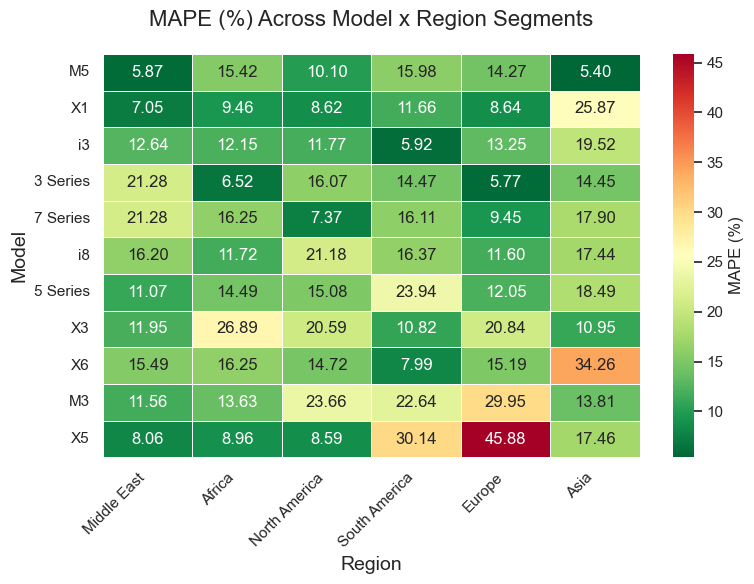

Region,Africa,Asia,Europe,Middle East,North America,South America,Overall
Model,,,,,,,
3 Series,6.517786,14.446947,5.768811,21.277453,16.068520,14.468922,13.091406
5 Series,14.487394,18.489376,12.054792,11.068589,15.083836,23.942918,15.854484
7 Series,16.254629,17.897758,9.453584,21.283880,7.370320,16.113467,14.728940
M3,13.632646,13.810976,29.953401,11.563606,23.655626,22.638523,19.209130
M5,15.416574,5.396423,14.271114,5.869152,10.101552,15.977909,11.172121
X1,9.461219,25.872730,8.644244,7.054313,8.619857,11.659888,11.885375
X3,26.889400,10.950389,20.838265,11.948002,20.593631,10.816935,17.006104
X5,8.960642,17.461700,45.878083,8.057019,8.591851,30.137169,19.847744
X6,16.245147,34.255276,15.190565,15.488365,14.717774,7.994625,17.315292


In [8]:
df_matrix = perf.pivot(index='Model', columns='Region', values='MAPE_%')

df_matrix = df_matrix.loc[df_matrix.mean(axis=1).sort_values(ascending=True).index]
df_matrix = df_matrix[df_matrix.mean(axis=0).sort_values(ascending=True).index]

# sort best -> worst

plt.figure(figsize=(8,6))
sns.set_theme(style='white')

sns.heatmap(
    df_matrix,
    annot= True,
    fmt = '.2f',
    cmap = 'RdYlGn_r',
    linewidths=0.5,
    cbar_kws={'label': 'MAPE (%)'}
)

plt.title('MAPE (%) Across Model x Region Segments', fontsize=16, pad=20)
plt.xlabel("Region", fontsize = 14)
plt.ylabel('Model', fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

display(pd.pivot_table(perf, values="MAPE_%", index='Model', columns='Region', aggfunc='mean',margins=True, margins_name='Overall'))

Key findings:
- Average MAPE across 66 segments ≈ 15.3%, acceptable for annual automotive forecasting
- Many segments show MAPE < 10%, reflecting strong predictive stability
- Most others fall between 10–20%, which is usable for planning
- A small number exceed 30%, driven by structural volatility

Overall, Prophet performs reliably for the majority of segments and forms a strong baseline model. Volatile segments can be improved using external regressors or hybrid ML approaches.

## 5. Forecasts, Visualisations, and Insights

18:48:46 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing
18:48:46 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing
18:48:46 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing
18:48:46 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing
18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing
18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing
18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing
18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing
18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1]

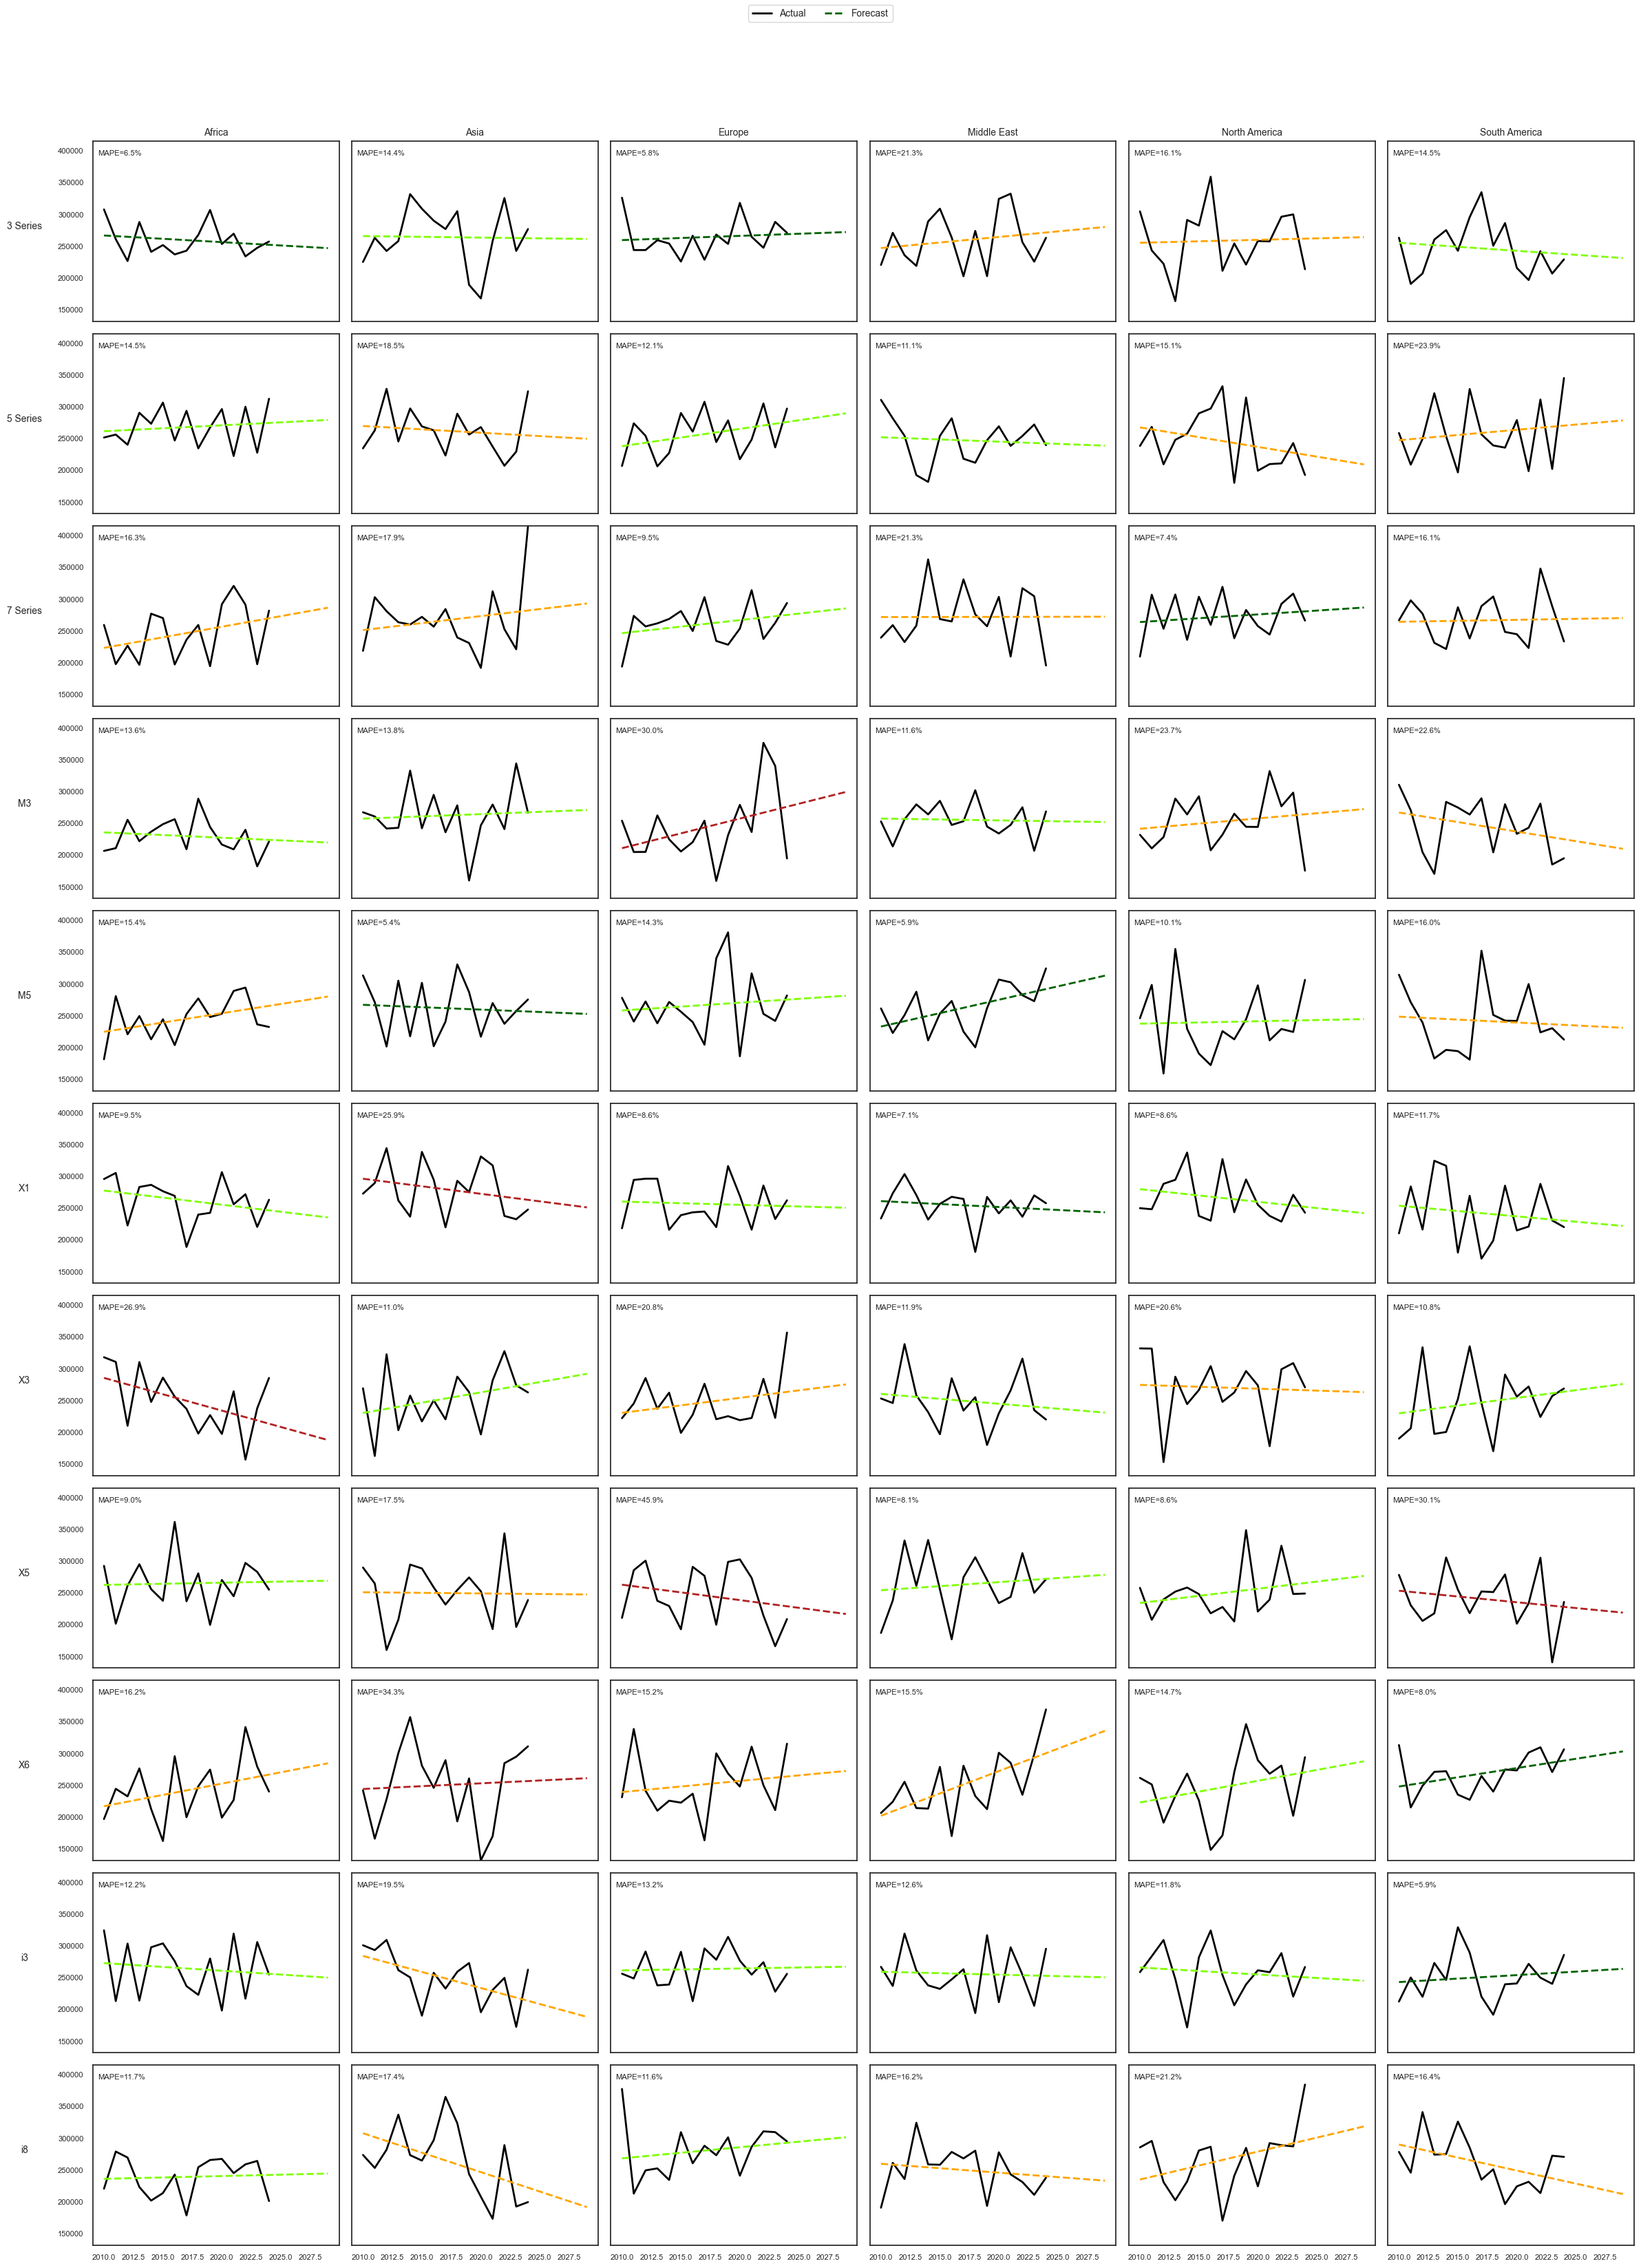

In [11]:
all_forecasts = []
future_horizon_years = 5

for (model, region), grp in df_ts.groupby(['Model', 'Region']):
    grp = grp.sort_values('Year')

    if len(grp) < 3:
        continue

    # Fit on ALL available data
    df_p = grp.rename(columns={'Year': 'ds', 'Total_Sales': 'y'})
    df_p['ds'] = pd.to_datetime(df_p['ds'], format='%Y')

    m = Prophet(yearly_seasonality=False)
    m.fit(df_p)

    # history + future
    future = m.make_future_dataframe(periods=future_horizon_years, freq='YS')
    fcst = m.predict(future)[['ds', 'yhat']].copy()
    fcst['Year'] = fcst['ds'].dt.year

    # merge actuals (will be NaN for future years)
    merged = fcst.merge(
        grp[['Year', 'Total_Sales']],
        on='Year',
        how='left'
    )

    merged['Model'] = model
    merged['Region'] = region

    all_forecasts.append(merged)

df_plot = pd.concat(all_forecasts, ignore_index=True)
df_plot.rename(columns={'Total_Sales': 'Actual', 'yhat': 'Predicted'}, inplace=True)

# Prepare for plot
df_plot = df_plot.merge(
    perf[['Model', 'Region', 'MAPE_%']],
    on=['Model', 'Region'],
    how='left'
)

def mape_color(mape):
    if pd.isna(mape):
        return "gray"
    if mape < 8:
        return "#006400"   # very good – dark green
    elif mape < 15:
        return "#7FFF00"   # good – light green
    elif mape < 25:
        return "#FFA500"   # unstable – orange
    else:
        return "#B22222"   # bad – red

models = sorted(df_plot['Model'].unique())
regions = sorted(df_plot['Region'].unique())

fig, axes = plt.subplots(
    nrows=len(models),
    ncols=len(regions),
    figsize=(4 * len(regions), 3 * len(models)),
    sharex=True,
    sharey=True
)

axes = np.atleast_2d(axes)  # ensure 2D indexing

ymin = df_plot['Actual'].min()
ymax = df_plot['Actual'].max()

for ax_row in axes:
    for ax in ax_row:
        ax.set_ylim(ymin, ymax)
# --- 4. Plot each (Model, Region) segment ---
for i, model in enumerate(models):
    for j, region in enumerate(regions):
        ax = axes[i, j]

        seg = (
            df_plot[(df_plot['Model'] == model) &
                    (df_plot['Region'] == region)]
            .sort_values('Year')
        )

        if seg.empty:
            ax.axis("off")
            continue

        mape = seg['MAPE_%'].iloc[0]

        # Actual = black, Forecast = color based on MAPE
        ax.plot(seg['Year'], seg['Actual'],
                color="black", linewidth=2, label="Actual")
        ax.plot(seg['Year'], seg['Predicted'],
                color=mape_color(mape), linewidth=2,
                linestyle="--", label="Forecast")

        # Top row: region titles
        if i == 0:
            ax.set_title(region, fontsize=10)

        # First column: model labels on y-axis
        if j == 0:
            ax.set_ylabel(model, fontsize=10,
                          rotation=0, labelpad=35)

        ax.tick_params(labelsize=8)

        # Small MAPE label inside subplot
        ax.text(
            0.02, 0.95,
            f"MAPE={mape:.1f}%",
            transform=ax.transAxes,
            fontsize=8,
            va="top"
        )

# --- 5. One shared legend ---
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The forecast matrix displays:
- Actuals (black) across full history
- Forecasts (colored dashed lines) for 5 future years
- Color-coded MAPE to indicate model reliability
- Shared Y-axis for easier comparison of volatility across models/regions

This layout allows immediate identification of:
- Stable vs. unstable market segments
- Regions with consistent long-term trends
- Segments where Prophet diverges due to irregular or noisy history

The approach provides a transparent, executive-ready forecasting visualization.

In [12]:
# export the forecast results
output_path_csv = "../exports/bmw_forecasts_5yr.csv"
df_plot.to_csv(output_path_csv, index=False)

print("✅ Forecast data exported to:", output_path_csv)

✅ Forecast data exported to: ../exports/bmw_forecasts_5yr.csv


## 6. Recommendations
1. Priorities planning around high-confidence segments (MAPE < 15%):
    - Models such as 3 Series, M5, X1, I3, and serveral Middle East / Africa segments show strong predictive alignment between historical and forecasted values. These segments should anchor production planning, inventory allocation, and revenue forecasting becase the model provides consistent directional accuracy.
2. Apply scenario planning and buffer ranges to violate regions and models:
    - Segments with ogrange or red forecast lines, especially X3, X5, X6, M3, and certain Asia / Europe regions, show historically irregular behavior that reduce forecast precision. For these segments, leadership should incorporate high/medium/low scenarios rather than a single deterministic outlook, building flexibility into sales and supply plans.
3. Ehance forecasting for unstable segments using external drivers:
    - The most volatile patterns likely require more than time-series data. By intergrating macroeconomic indicators (GDP, CPI, auto sales index), competitive activity, fuel prices, and model-launch cycles, leadership can significantly improve predictive accuracy in segments with high MAPE.
4. Segment portforlio strategy by forecast confidence:
    - High-confidence segments: Focus on volume commiments, production efficiency, and growth captures.
    Medium-confidence segments: Monitor quaterly, adjust target dynamically.
    Low-confidence segments: Treat as strategic risks by tightening enventory, de-risking supply chain exposure, or exploring model refresh / marketing levers.
5. Allocate attention to high-volume markets:
    - Forecasts clearly show large absolute volume in certain models (X-series, M-series) regardless of MAPE. These are impactful segments where forecast errors carries higher business cost. Thus, leadership should apply tighter governance and more frequent reforecasting here.
6. Implement a more advanced forecasting model for critical but volatile segments:
    - Combining Prophet with gradient bossing (XGBoost/LightGBM) or ensemble models can stablilise predictions in markets with structural shift. This particularly recommended for X5/X6 in Asia and Europe, where red forecast lines indicate systematic divergence.
7. Implement a continuous model monitoring loop
    - Given the variability seen in some regions, leadership should adopt a monthly or quarterly backtest-monitor-update cycle. This reduce longterm drift and ensures forecasts adjust quickly to new realities.

## 7. Conclusion
This project delivers a complete forecasting workflow that processes raw BMW sales data, evaluates Prophet across 66 Model × Region segments, and produces 5-year forecasts supported by structured visualisations and actionable insights. The model performs well in most segments, provides reliable forward-looking guidance, and highlights areas of high uncertainty. The final system forms a strong foundation for scalable forecasting, with clear pathways for enhancement using external drivers or hybrid ML methods.